# **Chess Upsets Amongst Bots**

**Name: Cameron Andrews**

**Introduction:**

This aim of this project is to explore an interesting phenomenon within the world of chess, yet it will not focus on any human chess players. Instead this project will focus on chess matches between two opposing chess engines, of different and randomly selected ELO ratings.

At first you may believe that the chess engine with a higher ELO rating would always win, simply because chess is known to be a game of perfect information, and therefore the more skilled engine should win against a lesser skilled engine every time. However, by simulating thousands of games under these circumstances, it is noticeable that this is not the case, and that even when there is a large discrepancy amongst the two ELOs, an upset is still possible. This project will aim to analyze the occurrence of upsets between chess engines, and determine whether there may be telling signs of when an upset is possible, and perhaps even train a model to become the upset master.

But first, we must gather the data!

**Data Creation:**

This project will utilize a famous chess engine called "Stockfish", and in the process we will create two different engines; one to play the white pieces, and one for the black pieces. At the beginning of each simulation we will randomly select an ELO rating between 200 and 2500 for each engine. For reference, the highest ranked human chess player in the world, Magnus Carlsen, currently has an ELO floating around 2800.

First, in order to run this script you will need to have access to the Stockfish executable (Downloadable from their website @ https://stockfishchess.org/download). After downloading, you will need to specify the executable path as seen in the code below.

After that you should be able to run this script and generate your own chess data to analyze. However, this script takes several hours to run, and therefore the script will first check to see whether this data has already been created, and if found, will use that instead. Because the resulting CSV file is large (around 500mb), I have decided to split up the CSV into 5 smaller files, that way they can be uploaded to the Github repository and anyone interested in analyzing this data won't have to wait for hours to have fun analyzing!

In [26]:
import chess
import pandas
import numpy as np
import glob
import matplotlib.pyplot as plt
from stockfish import Stockfish
from io import StringIO

preexisting_data_files = glob.glob('Data/chess_data_*.csv', recursive=True)

if len(preexisting_data_files) == 0:

    # Set the number of simulations to run.
    NUM_SIMS = 50000
    chess_df = pandas.DataFrame(columns=["FEN", "MOVES_DF", "NUM_MOVE_PAIRS", "RESULT", "WINNER", "WHITE_ELO", "BLACK_ELO", "UPSET"])

    for i in range(NUM_SIMS):

        # Configure Two StockFish Chess Engines of unique ELO ratings that will fight eachother
        white_stockfish = Stockfish("stockfish_14.1_win_x64_avx2/stockfish_14.1_win_x64_avx2.exe")
        white_elo = int(np.random.uniform(200, 2500))
        white_stockfish.set_elo_rating(white_elo)

        black_stockfish = Stockfish("stockfish_14.1_win_x64_avx2/stockfish_14.1_win_x64_avx2.exe")
        black_elo = int(np.random.uniform(200, 2500))
        black_stockfish.set_elo_rating(black_elo)

        # Initializing a new chess board
        board = chess.Board()

        # Creating a new DataFrame to Keep track of all moves in the game
        moves_df = pandas.DataFrame( columns=["FEN_BEFORE_MOVE", "MOVE_MADE", "TURN"])

        # Making moves until the game ends
        while not board.is_game_over():
            white_stockfish.set_fen_position(board.fen())
            white_next_move = white_stockfish.get_best_move()

            # Appending the current move to a separate DataFrame that tracks all moves made throughout a game
            moves_df = moves_df.append({"FEN_BEFORE_MOVE": board.fen(), "TURN": "WHITE", "MOVE_MADE": white_next_move}, ignore_index=True)
            board.push_uci(white_stockfish.get_best_move())

            black_stockfish.set_fen_position(board.fen())
            black_next_move = black_stockfish.get_best_move()

            # Must check if the game is already over before proceeding
            if black_next_move is not None:
                # Appending the current move to a separate DataFrame that tracks all moves made throughout a game
                moves_df = moves_df.append({"FEN_BEFORE_MOVE": board.fen(), "TURN": "BLACK", "MOVE_MADE": black_next_move}, ignore_index=True)
                board.push_uci(black_next_move)

        # Cleaning the string containing the game's outcome
        result = str(board.outcome(claim_draw=True).termination).replace("Termination.", "")

        # Checks the results of the game and sets a few different variables accordingly
        if result == "CHECKMATE":

            upset = False

            if board.outcome(claim_draw=True).winner == True:
                winner = "WHITE"

                if white_elo < black_elo:
                    upset = True
            else:
                winner = "BLACK"

                if black_elo < white_elo:
                    upset = True
        else:
            winner = None
            upset = "N/A"

        # Adds the game data to the main chess_df DataFrame
        chess_df = chess_df.append(
            {"FEN": board.fen(), "MOVES_DF": moves_df.to_csv(), "NUM_MOVE_PAIRS": board.fullmove_number, "RESULT": result,
             "WINNER": winner, "WHITE_ELO": white_elo, "BLACK_ELO": black_elo, "UPSET": upset}, ignore_index=True)

    # Writes the DataFrame to a CSV file
    chess_df_1 = chess_df.iloc[:10000]
    chess_df_2 = chess_df.iloc[10000:20000]
    chess_df_3 = chess_df.iloc[20000:30000]
    chess_df_4 = chess_df.iloc[30000:40000]
    chess_df_5 = chess_df.iloc[40000:50000]

    chess_df_1.to_csv("Data/chess_data_1.csv")
    chess_df_2.to_csv("Data/chess_data_2.csv")
    chess_df_3.to_csv("Data/chess_data_3.csv")
    chess_df_4.to_csv("Data/chess_data_4.csv")
    chess_df_5.to_csv("Data/chess_data_5.csv")

else:

    chess_df = pandas.DataFrame()

    for file_path in preexisting_data_files:
        # Reading preexisting moves generated from an earlier simulation
        temp_df = pandas.read_csv(file_path)
        temp_df = temp_df.iloc[:, 1:]
        chess_df = pandas.concat([chess_df, temp_df], ignore_index=True)

    # Dropping the index column as it is repetitive
    chess_df = chess_df.iloc[:, 1:]

new_moves_column = []

# A little extra work has to be done to restore the moves of each game as a separate DataFrame per row
for fen, moves, num_move_pairs, result, winner, white_elo, black_elo, upset in chess_df.values:
    csv_string = StringIO(moves)
    moves_df = pandas.read_csv(csv_string, sep=",")
    moves_df = moves_df.iloc[:, 1:]
    new_moves_column.append(moves_df)

# Replacing old column continaing CSV strings with new column containing Pandas DataFrames
chess_df["MOVES_DF"] = new_moves_column

# Outputting the DataFrame
chess_df

,FEN,MOVES_DF,NUM_MOVE_PAIRS,RESULT,WINNER,WHITE_ELO,BLACK_ELO,UPSET
0,8/3Q4/3Q3k/4p1pp/PR2R2P/6P1/5KB1/8 b - - 0 51,FEN_BEF...,51,CHECKMATE,WHITE,661,1196,True
1,3kN3/8/8/6K1/b7/8/8/8 w - - 121 158,FEN_BEF...,158,FIVEFOLD_REPETITION,NaN,1015,598,NaN
2,5k2/8/1K4Q1/8/1B6/8/4n3/8 b - - 5 106,FEN_BEF...,106,CHECKMATE,WHITE,915,1157,True
3,4Qk1r/2q3b1/p2N2P1/2P2bBp/1P1n4/P1p5/R4PB1/4K3...,FEN_BEFO...,37,CHECKMATE,WHITE,264,639,True
4,8/p6Q/P1Q2k2/R7/4p1p1/4P3/3K4/8 b - - 1 64,FEN_BEF...,64,CHECKMATE,WHITE,241,1125,True
...,...,...,...,...,...,...,...,...
49995,8/8/4R3/6k1/r3p2p/4K3/1pr5/4r3 w - - 3 61,FEN_BEF...,61,CHECKMATE,BLACK,741,1012,False
49996,7k/3PQ2Q/4p1r1/4Pp1p/5P2/3R3P/4R1p1/4Q1K1 b - ...,FEN_BEF...,102,CHECKMATE,WHITE,2401,1613,False
49997,Q7/4Q1kp/6p1/4N1P1/2p1p3/2P5/6P1/1B3RK1 b - - ...,FEN_BEF...,55,CHECKMATE,WHITE,2107,303,False
49998,7r/4Q2p/p5p1/1b5k/1p4N1/P5N1/2P1BPPP/3K3R b - ...,FEN_BEFO...,35,CHECKMATE,WHITE,1532,2036,True


**What Now?**

After that first cell has completed running, you should now be in possession of a Pandas DataFrame containing the results of 50,000 simulated chess matches. The DataFrame has 8 columns in total, with the first being the FEN (Forsyth–Edwards Notation, a standard way for describing board position) at the end of the game. The next column contains a separate DataFrame with all the individual moves made during that particular game. Now after running 50,000 simulations, we will have over 6,000,000 moves to analyze. The DataFrame also contains a count of move pairs made during the match, the match result, winner, ELO rankings, and a boolean column describing whether the match ended in an upset, where the lower ranked engine beat the higher ranked.

So now that we have a Pandas DataFrame containing the results of our simulation, we can begin to explore the data and determine whether there are any common traits amongst games that ended in an upset.

In [27]:
print("Ratio of Total Games that Ended in an Upset:")
print("Ended in Upset:", chess_df["UPSET"].value_counts()[True])
print("Didn't End in Upset:", chess_df["UPSET"].value_counts()[False], "\n")
percentage = round((chess_df["UPSET"].value_counts()[True] / len(chess_df)) * 100, 3)
print(f"Percentage of Total Games that Ended in Upset: {percentage} %")


Ratio of Total Games that Ended in an Upset:
Ended in Upset: 16822
Didn't End in Upset: 31286 

Percentage of Total Games that Ended in Upset: 33.644 %


Clearly it appears that a fairly significant number of games end up in an upset, and in my testing it also seems that the percentage of upsets remains around 33% regardless of the number of simulations ran.

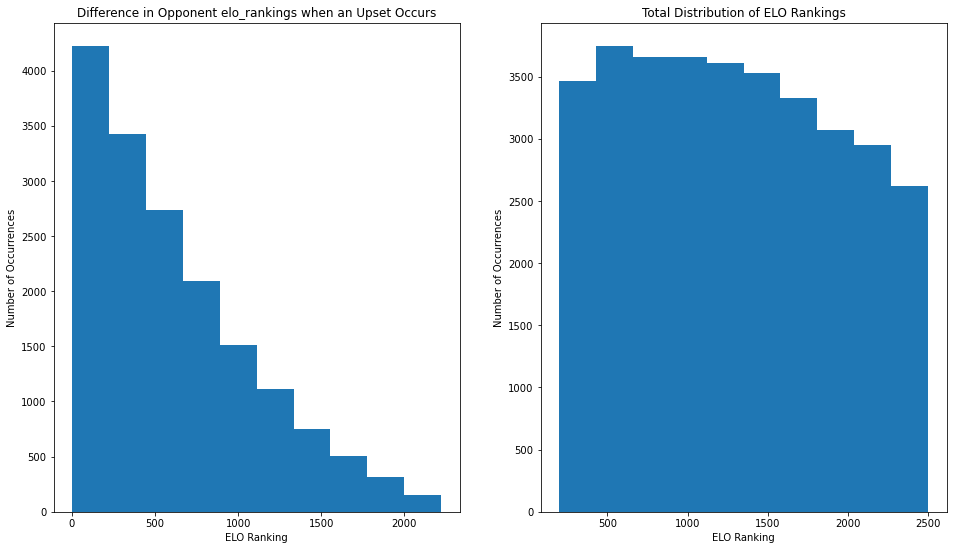

In [37]:
# Filtering the pandas dataframe to only see games that ended in an upset
chess_upsets_df = chess_df.query("UPSET == True")

# Two lists that will hold total ELO rankings, as well as the difference between ELO amongst opponents
elo_rankings = []
differences = []

# Looping through dataframe to retrieve ELO rankings and differences
for fen, moves, num_move_pairs, result, winner, white_elo, black_elo, upset in chess_upsets_df.values:
    elo_rankings += [white_elo, black_elo]
    differences.append(abs(white_elo - black_elo))


fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=False)
fig.set_figwidth(16)
fig.set_figheight(9)
# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(differences)
axs[0].set_title("Difference in Opponent elo_rankings when an Upset Occurs")
axs[0].set_xlabel("ELO Ranking")
axs[0].set_ylabel("Number of Occurrences")

axs[1].hist(elo_rankings)
axs[1].set_title("Total Distribution of ELO Rankings")
axs[1].set_xlabel("ELO Ranking")
axs[1].set_ylabel("Number of Occurrences")


plt.show()

Based on the plots above, we can confirm that ELO rankings are *mostly* drawn from a uniform distribution as we specified earlier. But what else is interesting is that it seems the number of upsets decreases exponentially with a larger difference in the ELO rankings of opponents. This makes sense as it is surely more likely that an upset would occur between closely ranked opponents, but nonetheless it can still happen even with differences larger than 2000!